# InSituPy demonstration - Cell type annotation

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import InSituData, CACHE
import pandas as pd
from insitupy.utils import generate_mock_reference
import scanpy as sc
import numpy as np

## Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to the `InSituPy` project folder.

In [3]:
insitupy_project = Path(CACHE / "out/demo_insitupy_project")

In [4]:
xd = InSituData.read(insitupy_project)

In [5]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\.cache\InSituPy\out\demo_insitupy_project
Metadata file:	.ispy

No modalities loaded.

In [6]:
xd.load_all(skip="transcripts")

In [7]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\.cache\InSituPy\out\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 163565 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
           obsm: 'X_pca', 'X_umap', 'annotations', 'regions', 'spatial'
           varm: 'PCs'
           layers: 'counts', 'norm_counts'
           obsp: 'connectivities', 'distances'
       boundaries
           BoundariesData object with 2 entries:
               cells
               nuclei
    ➤ annotations
   

## Prepare panel

In [8]:
# load panel annotated
panel = pd.read_csv("./demo_panel/Xenium_hBreast_v1_metadata.csv")
panel.head()

,Genes,Ensembl_ID,Num_Probesets,Codewords,Annotation
0,ABCC11,ENSG00000121270,7,1,Breast cancer
1,ACTA2,ENSG00000107796,8,1,Smooth muscle cells
2,ACTG2,ENSG00000163017,8,1,Breast myoepithelial cells
3,ADAM9,ENSG00000168615,8,1,Breast glandular cells
4,ADGRE5,ENSG00000123146,8,1,Dendritic cells


In [9]:

# Remove ambiguous terms ("Immune cells")
panel = panel[~(panel["Annotation"] == "Immune cells")].copy()
panel = panel[~(panel["Annotation"] == "Epithelial cells")].copy()
panel["Annotation"].unique()

array(['Breast cancer', 'Smooth muscle cells',
       'Breast myoepithelial cells', 'Breast glandular cells',
       'Dendritic cells', 'Adipocytes', 'Macrophages',
       'Endothelial cells', 'B cells', 'Fibroblasts', 'T cells',
       'Monocytes', 'NK cells', 'Neutrophils', 'Mast cells',
       'Myeloid cells', 'Plasma cells'], dtype=object)

# Cell annotation

There are many ways to annotate cell types and which one is the best depends a lot on the specific dataset. Below we will introduce two marker gene-based approaches. As source for the marker genes we use the _Xenium In Situ_ panel but any other kind of marker gene resource would also be valid.

Here is a list of available tools for cell type annotation/label transfer (only the first two are showcased here):
- Decoupler (use statistical methods to test whether a set of marker genes is enriched in a particular cell  population (cluster)): 
  https://decoupler-py.readthedocs.io/en/latest/
- TACCO (uses optimal transport methods to transfer labels from a reference to a target dataset): https://www.nature.com/articles/s41587-023-01657-3
- Celltypist (automated cell type annotation tool for scRNA-seq datasets on the basis of logistic regression classifiers optimised by the stochastic gradient descent algorithm): 
https://www.celltypist.org, https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial.ipynb

- SCANVI (semi-supervised model for single-cell transcriptomics data):
  https://docs.scvi-tools.org/en/latest/user_guide/models/scanvi.html

## Option 1: Decoupler

This approach is based on Over Representation Analysis (ORA) using the [`decoupler` package](https://decoupler-py.readthedocs.io/en/latest/index.html). A detailed description of this approach can be found [here](https://decoupler-py.readthedocs.io/en/latest/notebooks/cell_annotation.html). 

In [ ]:
# install decoupler
!pip install decoupler==1.8.0

In [12]:
import decoupler as dc

### Run Over Representation Analysis (ORA)

In [13]:
dc.run_ora(mat=xd.cells.matrix,
           net=panel,
           source='Annotation',
           target='Genes', min_n=3,
           verbose=True, use_raw=False)

Running ora on mat with 163565 samples and 313 targets for 14 sources.


100%|██████████| 163565/163565 [00:39<00:00, 4128.07it/s]


In [14]:
xd.cells.matrix.obsm['ora_estimate']

source,Adipocytes,B cells,Breast cancer,Breast glandular cells,Breast myoepithelial cells,Dendritic cells,Endothelial cells,Fibroblasts,Macrophages,Mast cells,Monocytes,NK cells,Smooth muscle cells,T cells
1,-0.0,-0.000000,7.957821,11.744824,1.923098,-0.0,2.057146,1.952898,-0.000000,2.620115,-0.0,-0.0,-0.000000,-0.000000
2,-0.0,1.686005,10.415684,11.744824,4.203273,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.000000
5,-0.0,1.686005,3.505476,11.744824,-0.000000,-0.0,-0.000000,1.952898,1.686005,-0.000000,-0.0,-0.0,-0.000000,1.558372
8,-0.0,-0.000000,5.646166,11.744824,1.923098,-0.0,-0.000000,1.952898,1.686005,-0.000000,-0.0,-0.0,1.952898,1.558372
9,-0.0,-0.000000,7.957821,7.141194,4.203273,-0.0,-0.000000,1.952898,5.966584,2.620115,-0.0,-0.0,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167776,-0.0,-0.000000,18.553878,7.141194,1.923098,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.000000
167777,-0.0,-0.000000,18.553878,9.380036,4.203273,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.000000
167778,-0.0,-0.000000,18.553878,11.744824,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.000000
167779,-0.0,-0.000000,15.719712,7.141194,1.923098,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.000000


In [15]:
acts = dc.get_acts(xd.cells.matrix, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

In [16]:
acts

AnnData object with n_obs × n_vars = 163565 × 14
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden'
    uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'annotations', 'regions', 'spatial', 'ora_estimate', 'ora_pvals'

### Identify top predicted cell types per cluster

In [17]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')

In [18]:
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,Breast glandular cells,186.174370,4.779519,0.000000e+00,0.000000e+00
1,0,rest,Breast cancer,179.496167,6.819315,0.000000e+00,0.000000e+00
2,0,rest,Mast cells,-14.440440,-0.043136,4.087310e-47,4.087310e-47
3,0,rest,Breast myoepithelial cells,-24.291277,-0.392602,1.482420e-129,1.596452e-129
4,0,rest,Monocytes,-43.713220,-0.184248,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...
191,9,rest,Macrophages,-22.362713,-1.028981,1.679952e-107,3.359904e-107
192,9,rest,Dendritic cells,-22.545392,-0.282307,1.929359e-108,4.501839e-108
193,9,rest,Endothelial cells,-22.902340,-0.656542,1.483945e-111,4.155047e-111
194,9,rest,B cells,-25.662027,-0.817625,2.059410e-138,7.207935e-138


In [19]:
# transfer annotations to clusters
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'Breast glandular cells',
 '1': 'Fibroblasts',
 '10': 'B cells',
 '11': 'B cells',
 '12': 'Breast glandular cells',
 '13': 'Breast glandular cells',
 '2': 'Macrophages',
 '3': 'T cells',
 '4': 'T cells',
 '5': 'Breast cancer',
 '6': 'Breast cancer',
 '7': 'Endothelial cells',
 '8': 'Breast myoepithelial cells',
 '9': 'Breast cancer'}

In [20]:
xd.cells.matrix.obs['cell_type_dc'] = [annotation_dict[clust] for clust in xd.cells.matrix.obs['leiden']]

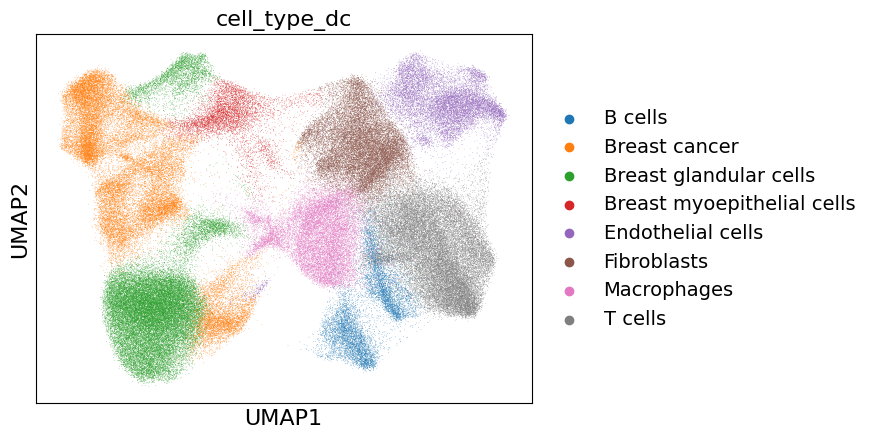

In [21]:
sc.pl.umap(xd.cells.matrix, color='cell_type_dc', save="_cell_type_dc.pdf")

### Caution!

This cell type annotation is only a demonstration and most probably contains inaccuracies. Cell type annotation needs to be done very carefully and results need to be double checked with pathological experts!

## Option 2: TACCO annotation transfer using a mock reference

For demonstration purposes, here we use the Xenium panel used for the breast cancer demo dataset to generate a mock single-cell RNA-seq reference.


In [23]:
# install tacco
!pip install tacco

   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 1.3/149.9 MB 7.4 MB/s eta 0:00:20
    --------------------------------------- 2.9/149.9 MB 7.3 MB/s eta 0:00:21
   - -------------------------------------- 4.5/149.9 MB 7.3 MB/s eta 0:00:21
   - -------------------------------------- 6.0/149.9 MB 7.2 MB/s eta 0:00:20
   - -------------------------------------- 7.1/149.9 MB 6.7 MB/s eta 0:00:22
   -- ------------------------------------- 9.2/149.9 MB 7.2 MB/s eta 0:00:20
   -- ------------------------------------- 10.7/149.9 MB 7.3 MB/s eta 0:00:20
   --- ------------------------------------ 12.1/149.9 MB 7.3 MB/s eta 0:00:19
   --- ------------------------------------ 13.6/149.9 MB 7.3 MB/s eta 0:00:19
   ---- ----------------------------------- 15.2/149.9 MB 7.2 MB/s eta 0:00:19
   ---- ----------------------------------- 16.8/149.9 MB 7.2 MB/s eta 0:00:19
   ---- ----------------------------------- 18.4/149.9 MB 7.2 MB/s

In [24]:
import tacco as tc

In [27]:
# generate mock reference from gene panel
reference = generate_mock_reference(panel, annotation_column="Annotation", gene_column="Genes")
reference

AnnData object with n_obs × n_vars = 17 × 273
    obs: 'Annotation'

In [28]:
# set counts location
xd.cells.matrix.uns["counts_location"] = ['layer', 'counts']

In [29]:
# This is the annotation step. OT is our own annotation method, but theres multiple like rctd implemented in Tacco
# Theres also multiple parameters one could adjust, i ran everything with default
tc.tl.annotate(adata=xd.cells.matrix,
               reference=reference,
               annotation_key='Annotation',
               counts_location=None,  # if None it looks in `.uns["counts_location"]`
               result_key='OT',
               assume_valid_counts=False
               )

Starting preprocessing
Annotation profiles were not found in `reference.varm["Annotation"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 1.72 seconds.
Starting annotation of data with shape (163565, 273) and a reference of shape (17, 273) using the following wrapped method:
+- platform normalization: platform_iterations=0, gene_keys=Annotation, normalize_to=adata
   +- multi center: multi_center=None multi_center_amplitudes=True
      +- bisection boost: bisections=4, bisection_divisor=3
         +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  105.62331501831503 191.09373482455533
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 18.74 seconds.


AnnData object with n_obs × n_vars = 163565 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'cell_type_dc'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'cell_type_dc_colors', 'counts_location'
    obsm: 'X_pca', 'X_umap', 'annotations', 'regions', 'spatial', 'ora_estimate', 'ora_pvals', 'OT'
    varm: 'PCs', 'OT'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

In [30]:
# Tacco annotate returns non-absolute cell type percentages for each cell, since in other spatial methods
# cells can overlap on the measurement spots. This is to get the absolute annotation for each cell
tc.utils.get_maximum_annotation(xd.cells.matrix, 'OT', result_key='cell_type_tacco')

AnnData object with n_obs × n_vars = 163565 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'cell_type_dc', 'cell_type_tacco'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'cell_type_dc_colors', 'counts_location'
    obsm: 'X_pca', 'X_umap', 'annotations', 'regions', 'spatial', 'ora_estimate', 'ora_pvals', 'OT'
    varm: 'PCs', 'OT'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

In [31]:
xd.cells.matrix

AnnData object with n_obs × n_vars = 163565 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'cell_type_dc', 'cell_type_tacco'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'cell_type_dc_colors', 'counts_location'
    obsm: 'X_pca', 'X_umap', 'annotations', 'regions', 'spatial', 'ora_estimate', 'ora_pvals', 'OT'
    varm: 'PCs', 'OT'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

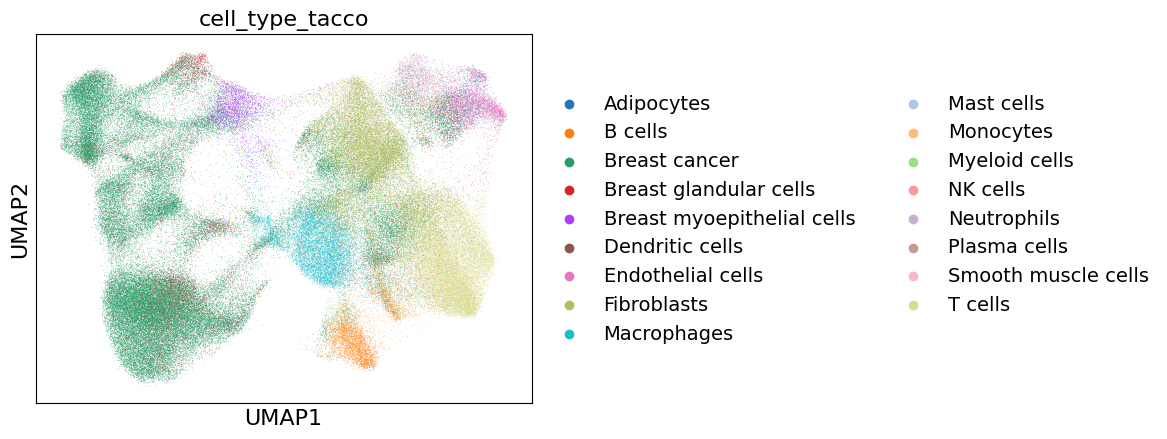

In [32]:
sc.pl.umap(xd.cells.matrix, color="cell_type_tacco", save="_cell_type_tacco.pdf")

## Visualization in napari

The cell type annotation can be selected in the "Show data" widget on the right under "observation" and then be displayed with the "Add" button:

<left><img src="./demo_screenshots/napari_cell_annotation_marked.jpg" width="1000"/></left>

When the the correct layer is selected in the layer list on the left, it is possible to hover with the mouse onto a cell and see the annotation of this cell on the bottom left under "value".



### Investigate the cellular composition of annotations and regions

In [33]:
xd.show()

In [34]:
xd.import_annotations(
    files="./demo_annotations/demo_annotations.geojson",
    keys="Demo",
    scale_factor=0.2125
)

In [35]:
xd.import_regions(
    files="./demo_regions/demo_regions.geojson",
    keys="Demo",
    scale_factor=0.2125
)

In [36]:
from insitupy.plotting import plot_cellular_composition

Assigning key 'Demo'...
Added results to `.cells.matrix.obsm['regions']
Saving figure to file figures/cell_composition_regions_Demo_dc.pdf
Saved.


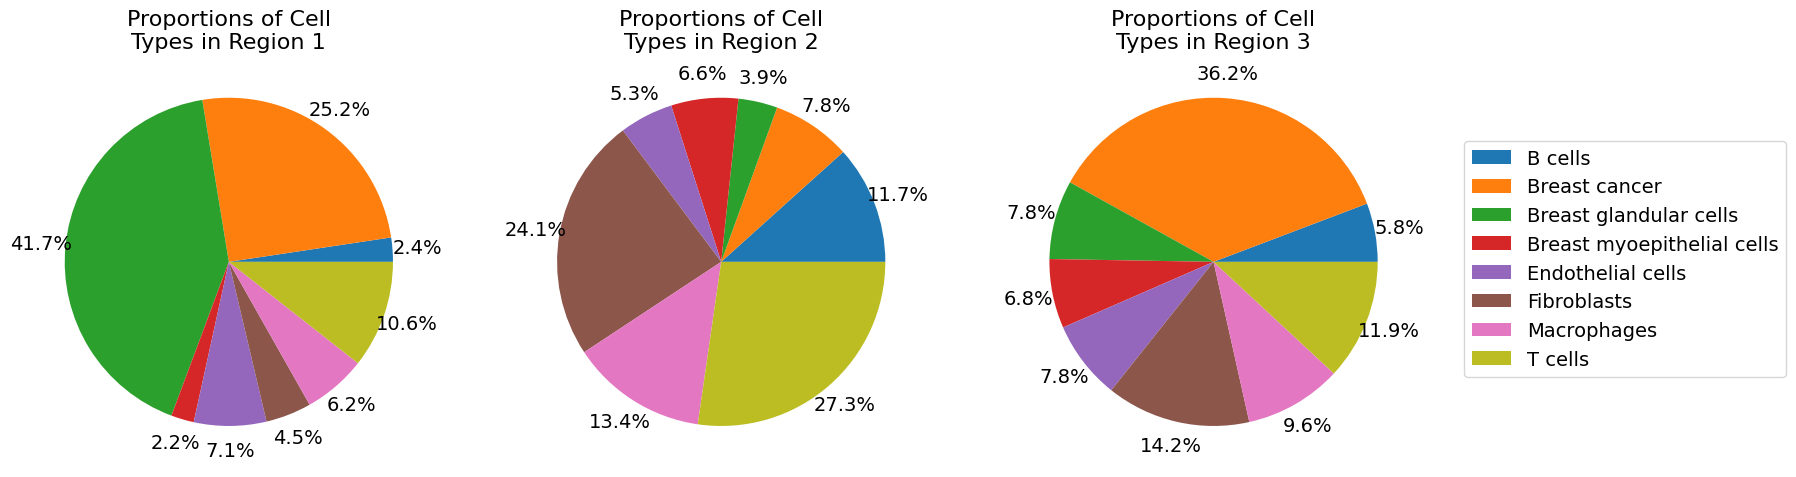

<Figure size 640x480 with 0 Axes>

In [37]:
plot_cellular_composition(
    data=xd, cell_type_col="cell_type_dc",
    key="Demo", modality="regions", max_cols=3, show_labels=True,
    savepath="figures/cell_composition_regions_Demo_dc.pdf"
)

Regions with key 'Demo' have already been assigned to the dataset.
Saving figure to file figures/cell_composition_regions_Demo_tacco.pdf
Saved.


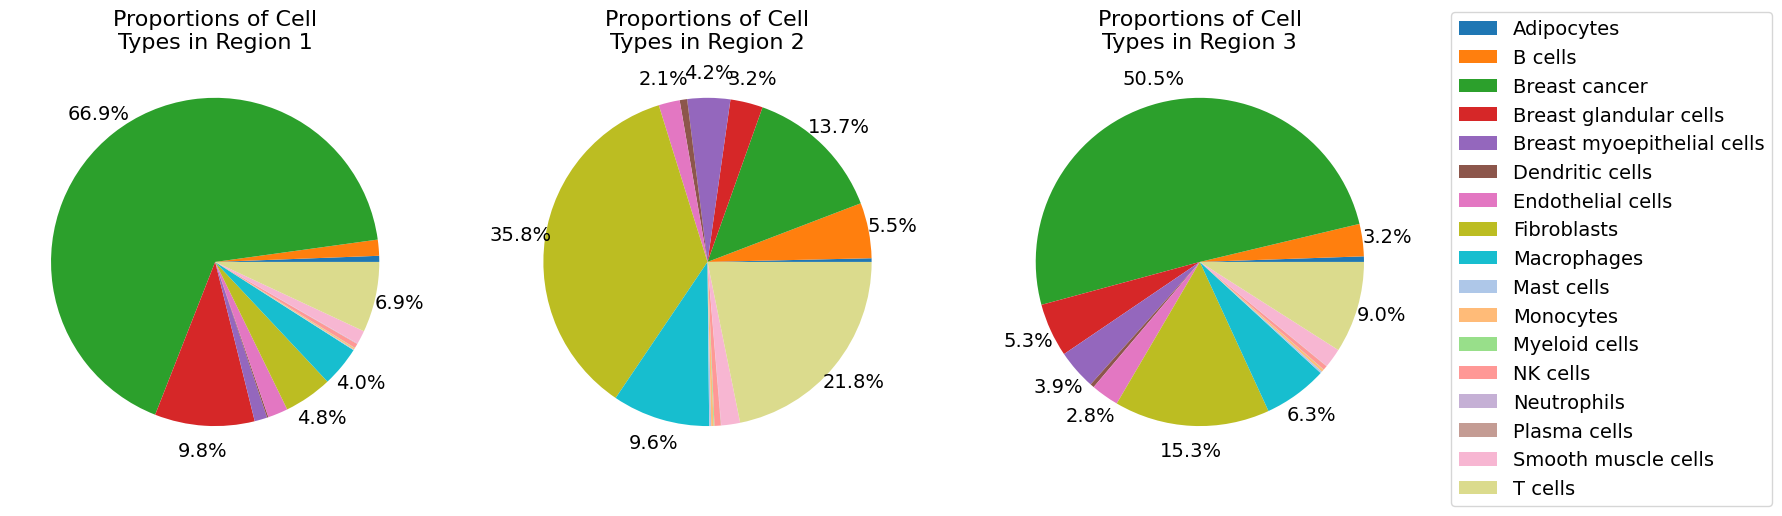

<Figure size 640x480 with 0 Axes>

In [38]:
plot_cellular_composition(
    data=xd, cell_type_col="cell_type_tacco",
    key="Demo", modality="regions", max_cols=3, show_labels=True,
    savepath="figures/cell_composition_regions_Demo_tacco.pdf"
)

Assigning key 'Demo'...
Added results to `.cells.matrix.obsm['annotations']
Saving figure to file figures/cell_composition_annotations_Demo_dc.pdf
Saved.


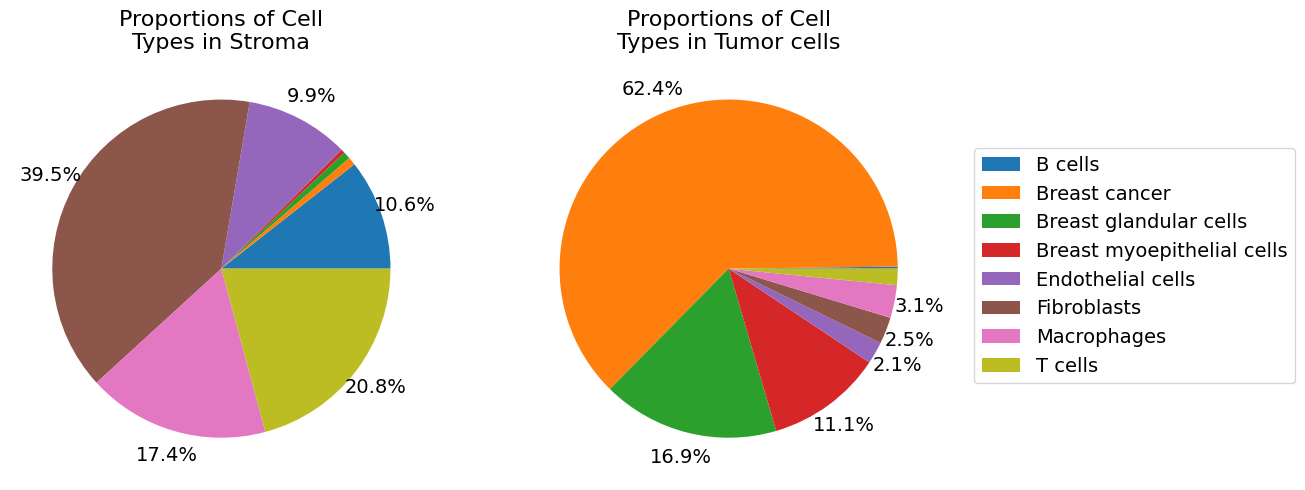

<Figure size 640x480 with 0 Axes>

In [39]:
plot_cellular_composition(
    data=xd, cell_type_col="cell_type_dc",
    key="Demo", modality="annotations", max_cols=3, show_labels=True,
    savepath="figures/cell_composition_annotations_Demo_dc.pdf"
)

Regions with key 'TMA' have already been assigned to the dataset.
Saving figure to file figures/cell_composition_TMA_dc.pdf
Saved.


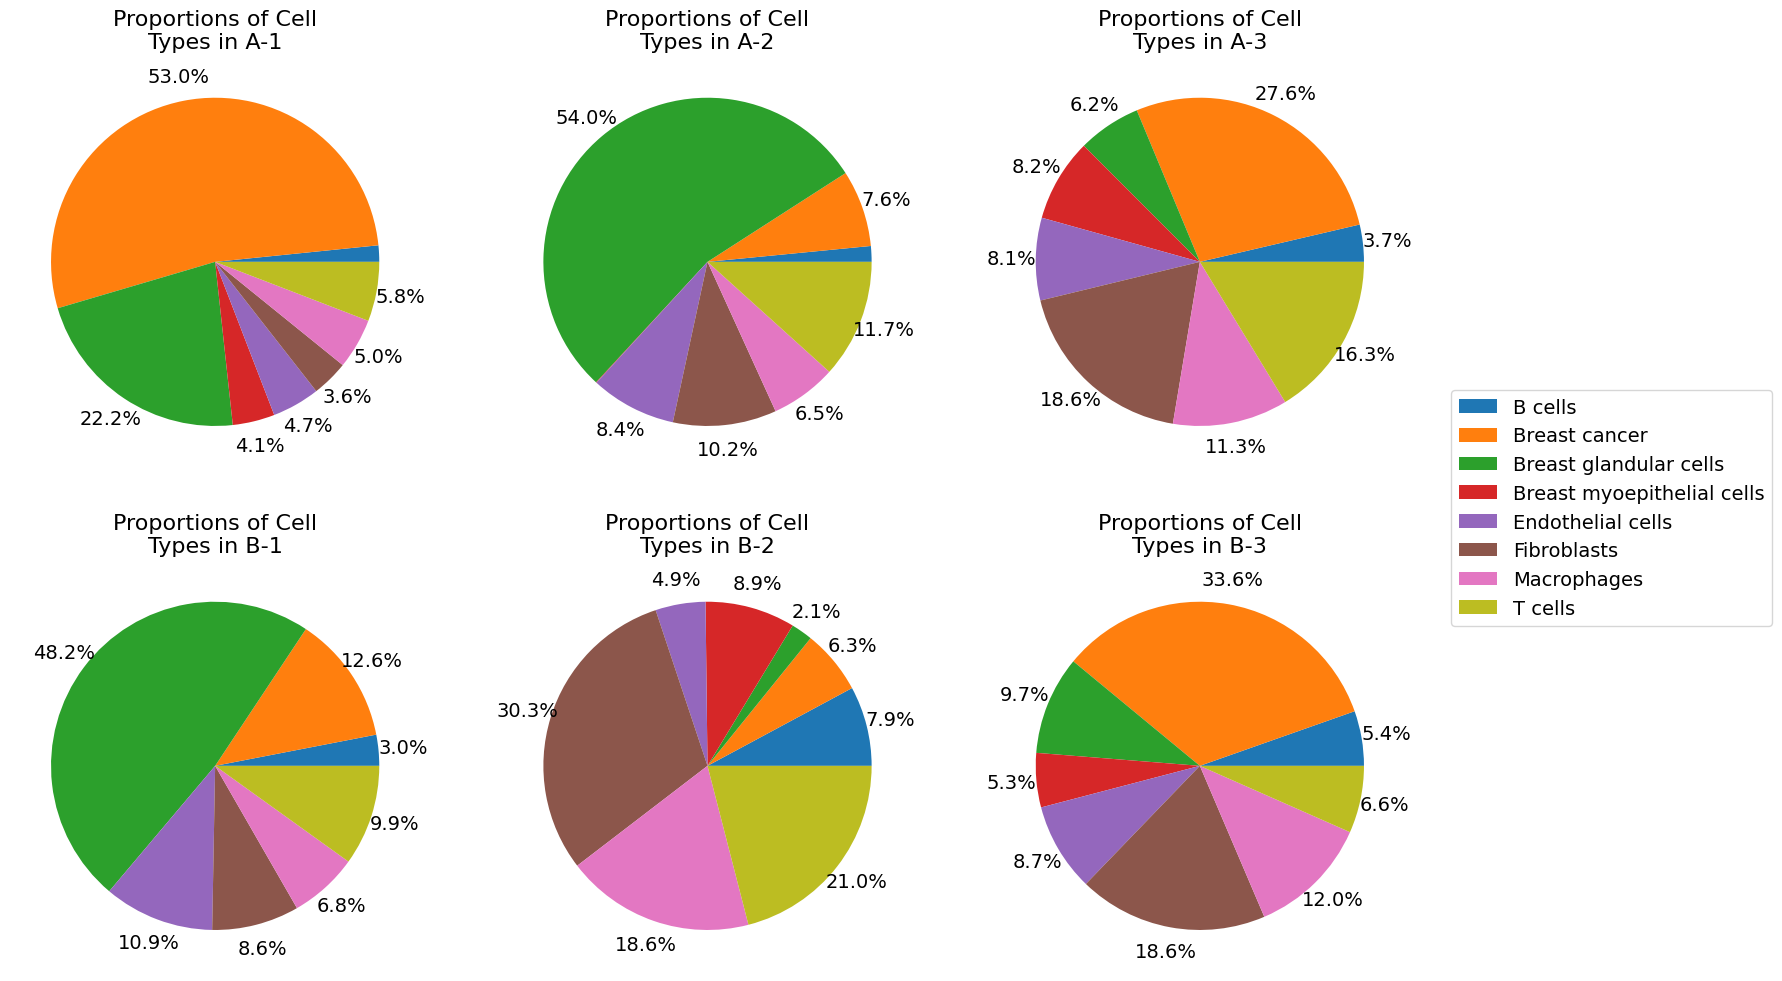

<Figure size 640x480 with 0 Axes>

In [40]:
plot_cellular_composition(
    data=xd, cell_type_col="cell_type_dc",
    key="TMA", modality="regions", max_cols=3, show_labels=True,
    savepath="figures/cell_composition_TMA_dc.pdf"
)

## Save results

In [41]:
xd.save()

Updating project in C:\Users\ge37voy\.cache\InSituPy\out\demo_insitupy_project
	Updating cells...
	Updating annotations...
	Updating regions...
Saved.
